# Schneider Electrick Hackaton - Data Science
## Team 4 - Gerard Jover Pujol - Pol Gràcia Espelt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Modules import

In [278]:
import os
import sklearn as sk
import pandas as pd
import numpy as np 
import requests as r
import pandas_profiling

## Data load

In [279]:
project_path = "/content/drive/MyDrive/Data_Science_&_AI/NUWE/"
train_data_dir_csv = [project_path + 'Data/CSV/' + x for x in os.listdir(project_path+'Data/CSV') if 'train' in x]
test_data_dir_csv = [project_path + 'Data/CSV/' + x for x in os.listdir(project_path+'Data/CSV') if 'test' in x][0]
train_data_dir_pdf = [project_path + 'Data/pdf/' + x for  x in os.listdir(project_path+'Data/pdf')]
train_data_api = project_path + 'Data/json/links.txt'

#### csv

Easily load the .csv files as pandas DataFrames and concatenate them.

In [284]:
df_csv = pd.concat([pd.read_csv(train_data_dir_csv[0]), pd.read_csv(train_data_dir_csv[1], sep = ';')])

In [285]:
df_csv.describe()

,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS
count,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000,37127.000000
mean,2012.951841,6.487031,14.540335,15.510519,18.013596,22.523559,9.452422,10.441560,13.431015,2.228217
std,3.856172,3.467030,8.128336,3.070188,2.313407,3.064919,5.232214,5.094000,5.225196,3.775751
min,2007.000000,1.000000,1.000000,8.062689,14.000287,15.055647,-3.141464,-0.199176,0.894827,0.000000
25%,2010.000000,3.000000,8.000000,13.315477,16.007158,20.361339,5.855159,7.158428,9.866841,0.000000
50%,2013.000000,7.000000,15.000000,15.503568,18.006838,22.553985,9.734382,10.733914,13.723792,1.000000
75%,2016.000000,9.000000,22.000000,17.708038,20.013530,24.713992,13.287165,14.162492,17.235091,2.000000
max,2020.000000,12.000000,28.000000,22.991382,21.999973,29.914367,20.855885,19.999403,24.855425,19.000000


### json (api)

Using the requests module we can call the API and retreive the data as json. This can later be transformed into a pandas DataFrame for better manipulation.

In [286]:
with open(train_data_api) as file:
    links = [link.strip() for link in file]

int_cols = ['MONTH','reportingYear', 'DAY', 'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp', 'min_temp', 'avg_temp', 'DAY WITH FOGS']
df_json = pd.DataFrame()
for link in links:
    data_json = r.get(link).json()
    tmp_df = pd.json_normalize(data_json)
    #set index
    tmp_df.set_index(tmp_df[''], inplace = True)
    tmp_df.drop('', axis = 1, inplace=True)
    #values to int
    tmp_df[int_cols] = tmp_df[int_cols].apply(pd.to_numeric)
    #print(tmp_df.columns)
    #concat
    df_json = pd.concat([json_df, tmp_df])
    #train_csv = pd.concat([train_csv, tmp_df])

In [287]:
df_json.describe()

,DAY,DAY WITH FOGS,MONTH,avg_temp,avg_wind_speed,max_temp,max_wind_speed,min_temp,min_wind_speed,reportingYear
count,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000,38002.000000
mean,14.503052,2.247145,6.481738,10.444782,18.024079,9.444586,15.527724,13.441732,22.525518,2012.919188
std,8.058339,3.793805,3.430652,5.058318,2.308109,5.184070,3.062454,5.191258,3.056839,3.851370
min,1.000000,0.000000,1.000000,-0.198657,14.000100,-3.075563,8.011958,0.895952,15.032589,2007.000000
25%,8.000000,0.000000,4.000000,7.210794,16.030198,5.894763,13.336093,9.905431,20.332273,2010.000000
50%,15.000000,1.000000,6.000000,10.638453,18.047094,9.636191,15.529569,13.635771,22.532040,2013.000000
75%,21.000000,2.000000,9.000000,14.210778,20.016093,13.256428,17.737102,17.297833,24.720514,2016.000000
max,28.000000,19.000000,12.000000,19.998645,21.999919,20.938266,22.947671,24.902108,29.933603,2020.000000


### Combine csv and json

In [288]:
df_bo = pd.concat([df_csv, df_json])

### pdf

For this we will use the library pdfplumber that allows us to extract the text from the pdf. We can later create a dictionary from the text extracted, and transform it again to a pandas DataFrame.

In [59]:
!pip install pdfplumber

In [289]:
import pdfplumber

def pdf_2_dict(pdf_path):
    # Extract text from pdf file
    with pdfplumber.open(pdf_path) as temp:
        first_page = temp.pages[0]
        text = first_page.extract_text()
        text_list = text.split("\n")

    # Create empty dict
    pdf_dict = {}

    # Generate new fields
    pdf_dict["id"] = int(text_list[1].split()[1])
    pdf_dict["facilityName"] = " ".join(text_list[2].split()[2:-1])
    pdf_dict["FacilityInspireID"] = text_list[3].split()[1]
    pdf_dict["countryName"] = " ".join(text_list[4].split("CONTINENT:")[0].split()[1:])
    pdf_dict["CONTINENT"] = " ".join(text_list[4].split("CONTINENT:")[1:])[1:]
    pdf_dict["City"] = " ".join(text_list[5].split()[1:])
    pdf_dict["EPRTRSectorCode"] = int(" ".join(text_list[6].split("eprtrSectorName:")[0].split()[1:]))
    pdf_dict["eprtrSectorName"] = " ".join(text_list[6].split("eprtrSectorName:")[1:])[1:]
    pdf_dict["EPRTRAnnexIMainActivityCode"] = text_list[7].split(":")[1]
    pdf_dict["targetRelease"] = " ".join(text_list[8].split("pollutant:")[0].split()[1:])
    pdf_dict["pollutant"] = " ".join(text_list[8].split("pollutant:")[1:])[1:]
    pdf_dict["emissions"] = float(text_list[9].split()[1].replace(",", "."))
    pdf_dict["DAY"] = int(text_list[10].split()[1])
    pdf_dict["MONTH"] = int(text_list[10].split()[3])
    pdf_dict["reportingYear"] = int(text_list[10].split()[5])
    pdf_dict["max_wind_speed"] = float(text_list[12].split()[1].replace(",", ".")) / 10e14
    pdf_dict["min_wind_speed"] = float(text_list[12].split()[3].replace(",", ".")) / 10e14
    pdf_dict["avg_wind_speed"] = float(text_list[12].split()[5].replace(",", ".")) / 10e14
    pdf_dict["max_temp"] = float(text_list[13].split()[1].replace(",", ".")) / 10e14
    pdf_dict["min_temp"] = float(text_list[13].split()[3].replace(",", ".")) / 10e14
    pdf_dict["avg_temp"] = float(text_list[13].split()[5].replace(",", ".")) / 10e14
    pdf_dict["DAY WITH FOGS"] = int(text_list[14].split()[-1])
    pdf_dict["REPORTER NAME"] = text_list[15].split("REPORTER NAME:")[-1]
    pdf_dict["CITY ID"] = text_list[16].split("CITY_ID ")[-1]

    return pdf_dict

In [290]:
df_pdf = pd.DataFrame()
for pdf_path in train_data_dir_pdf:
    pdf_dict = pdf_2_dict(pdf_path)
    pd_series = pd.Series(pdf_dict)
    df_pdf = df_pdf.append(pd_series, ignore_index=True)

In [291]:
df_pdf.describe()

,id,EPRTRSectorCode,emissions,DAY,MONTH,reportingYear,max_wind_speed,min_wind_speed,avg_wind_speed,max_temp,min_temp,avg_temp,DAY WITH FOGS
count,82.000000,82.000000,8.200000e+01,82.000000,82.000000,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,81555.902439,3.646341,7.835460e+07,13.573171,6.207317,2019.0,10.834402,15.984110,12.625050,10.558634,13.204793,9.851300,9.243902
std,24.210808,1.881502,2.256642e+08,7.933412,3.361870,0.0,6.578844,10.133739,7.572339,11.312655,9.616723,8.224411,5.514428
min,81516.000000,1.000000,1.010000e+05,1.000000,1.000000,2019.0,0.153000,0.217000,0.015100,-19.000000,0.203000,-20.000000,1.000000
25%,81535.250000,1.000000,1.902500e+05,7.000000,4.000000,2019.0,2.095000,2.345000,2.072500,6.355000,6.925000,4.632500,4.250000
50%,81555.500000,5.000000,3.840000e+05,13.500000,6.000000,2019.0,12.950000,20.350000,15.550000,9.605000,12.800000,9.555000,8.500000
75%,81576.750000,5.000000,1.197500e+06,19.750000,9.000000,2019.0,16.000000,23.950000,18.400000,13.975000,17.375000,14.725000,13.000000
max,81597.000000,6.000000,1.580000e+09,28.000000,12.000000,2019.0,21.400000,28.600000,21.900000,69.400000,65.400000,42.600000,19.000000


### Combine csv, json and pdf

In [352]:
df_final = pd.concat([df_bo, df_pdf])

In [353]:
df_final

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode,id,emissions
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015.0,10.0,...,2.864895,4.924169,9.688206,2.0,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018.0,9.0,...,5.462839,7.864403,12.023521,1.0,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019.0,2.0,...,1.511201,4.233438,8.632193,2.0,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012.0,8.0,...,10.970301,10.298348,15.179215,0.0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018.0,12.0,...,11.772039,11.344078,16.039004,2.0,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,United Kingdom,Energy sector,NaN,UK.SEPA/200002494.Facility,INEOS Infrastructure (Grangemouth) Ltd,Grangemouth,AIR,Nitrogen oxides (NOX),2019.0,1.0,...,24.700000,20.900000,6.440000,13.0,Kayla Fox,ce6badb6a385e25ce519dc600eb7402e,1(c),1.0,81588.0,468000.0
78,United Kingdom,Waste and wastewater management,NaN,UK.SEPA/200000098.Facility,"Summerston Landfill Site, Glasgow",Summerston,AIR,Methane (CH4),2019.0,4.0,...,6.930000,7.740000,9.220000,5.0,Sandra Wyatt,d90f4f7149ed3e451f4618f82734dae7,5(d),5.0,81531.0,163000.0
79,United Kingdom,Waste and wastewater management,NaN,UK.SEPA/200000101.Facility,"Battleby Landfill Site, Perth",Perth,AIR,Methane (CH4),2019.0,7.0,...,11.100000,11.000000,15.000000,4.0,Michael Cruz,4bc44fa25c7afaf63618e6586084052e,5(c),5.0,81532.0,354000.0
80,United Kingdom,Waste and wastewater management,NaN,UK.SEPA/200001325.Facility,"Dalinlongart Landfill Site, Sandbank",Dunoon,AIR,Methane (CH4),2019.0,1.0,...,10.400000,12.300000,17.000000,2.0,Joshua Oliver,bc9dc084a859e6b840b69d6146c646df,5(d),5.0,81569.0,148000.0


In [351]:
df_final

,countryName,eprtrSectorName,FacilityInspireID,facilityName,City,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,10,4,6785,3387,4137,0.0,2015,10,20,15,14,21,2,4,9,2,20,2
1,15,4,3413,6709,4364,2.0,2018,9,21,19,19,21,5,7,12,1,19,2
2,28,8,1328,1438,3347,1.0,2019,2,4,12,14,17,1,4,8,2,50,4
3,5,2,565,2632,2117,2.0,2012,8,6,11,16,17,10,10,15,0,2,0
4,8,8,6220,6874,4451,1.0,2018,12,22,17,20,21,11,11,16,2,52,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,31,2,6216,6510,4150,1.0,2019,4,16,12,14,18,15,1,2,6,-1,-1
60,31,6,6177,6784,175,2.0,2019,1,14,8,14,19,4,4,6,17,-1,-1
64,31,8,6155,4348,1116,1.0,2019,10,27,13,14,22,9,9,12,9,-1,-1
68,31,6,6190,1548,2029,0.0,2019,5,26,17,17,25,15,16,18,13,-1,-1


## Postprocessing

### Replace nans

Studying the data we've seen that 'EPRTRAnnexIMainActivityCode' and 'EPRTRSectorCode' represent the majority of our missing data (since 'id' and 'emissions' where only available at pdf data and therefore will not be used.

In [293]:
df_final.isna().sum()

countryName                         0
eprtrSectorName                     0
EPRTRAnnexIMainActivityLabel       82
FacilityInspireID                   0
facilityName                        0
City                                0
targetRelease                       0
pollutant                           0
reportingYear                       0
MONTH                               0
DAY                                 0
CONTINENT                           0
max_wind_speed                      0
avg_wind_speed                      0
min_wind_speed                      0
max_temp                            0
avg_temp                            0
min_temp                            0
DAY WITH FOGS                       0
REPORTER NAME                       0
CITY ID                             0
EPRTRAnnexIMainActivityCode     37127
EPRTRSectorCode                 37127
id                              75129
emissions                       75129
dtype: int64

We've discovered that we can obtain these missing fields by mapping them using the field 'EPRTRAnnexIMainActivityLabel' from other examples, which allows us to keep 37127 rows! Pretty nice :)

In [294]:
label2code = pd.DataFrame(df_final[['EPRTRAnnexIMainActivityLabel', 'EPRTRAnnexIMainActivityCode', 'EPRTRSectorCode']].value_counts()).reset_index()
label2code

,EPRTRAnnexIMainActivityLabel,EPRTRAnnexIMainActivityCode,EPRTRSectorCode,0
0,Thermal power stations and other combustion in...,1(c),1,12466
1,Landfills (excluding landfills of inert waste ...,5(d),5,6053
2,Installations for the incineration of non-haza...,5(b),5,2073
3,Installations for the production of cement cli...,3(c)(i),3,1991
4,"Installations for the manufacture of glass, in...",3(e),3,1611
...,...,...,...,...
65,Industrial plants for the preservation of wood...,6(c),6,6
66,Chemical installations for the production on a...,4(b)(iii),4,5
67,"Installations for the building of, and paintin...",9(e),9,4
68,Installations for the production on an industr...,4(f),4,3


In [295]:
label2SC = dict(zip(list(label2code.EPRTRAnnexIMainActivityLabel), list(label2code.EPRTRSectorCode)))
label2MAC = dict(zip(list(label2code.EPRTRAnnexIMainActivityLabel), list(label2code.EPRTRAnnexIMainActivityCode)))

In [296]:
f = lambda x: label2SC[x] if x not in ['Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds', np.nan] else np.nan
df_final['EPRTRSectorCode'] = df_final['EPRTRAnnexIMainActivityLabel'].apply(f)

In [297]:
f = lambda x: label2MAC[x] if x not in ['Chemical installations for the production on an industrial scale of basic organic chemicals: Organometallic compounds', np.nan] else np.nan
df_final['EPRTRAnnexIMainActivityCode'] = df_final['EPRTRAnnexIMainActivityLabel'].apply(f)

### Remove columns

We can remove some of the columns that don't add any value to our data or that are redundant

In [298]:
drop_cols = ["id", "emissions", "EPRTRAnnexIMainActivityLabel", "targetRelease", "CONTINENT", "CITY ID", "REPORTER NAME"]
df_final = df_final.drop(drop_cols, axis=1)

### Remove duplicated

As we can see we have 18070 rows duplicated, we have to remove them!

In [299]:
df_final.duplicated().sum()

18070

In [300]:
df_final = df_final[~df_final.duplicated()]

In [301]:
df_final.duplicated().sum()

0

### Change dtypes

We need to hoave all our data as numerical, so we need to fix two things:
  
- Transform floats to ints, since we dont have decimals and it will be cheaper to train
- Encode text data so that the model can interprete it. We've used an ordinal encoder provided as a pandas method, but sklearn offers more encoders (could be worth trying!) 

In [307]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [308]:
for col in df_final.columns:
    if col != "pollutant":
        if is_string_dtype(df_final[col]):
            print("str", col)
            df_final[col] = df_final[col].astype('category').cat.codes
        elif is_numeric_dtype(df_final[col]):
            print("int", col)
            df_final[col] = df_final[col].astype(np.int64)

str countryName
str eprtrSectorName
str FacilityInspireID
str facilityName
str City
int reportingYear
int MONTH
int DAY
int max_wind_speed
int avg_wind_speed
int min_wind_speed
int max_temp
int avg_temp
int min_temp
int DAY WITH FOGS
str EPRTRAnnexIMainActivityCode
str EPRTRSectorCode


### Target

To be able to transform and revert the transformation, we will be using the OrdinalEncoder from sklearn just for the label "pollutant"

In [309]:
from sklearn.preprocessing import OrdinalEncoder


ord_enc = OrdinalEncoder()
df_final["pollutant"] = ord_enc.fit_transform(df_final[["pollutant"]])
#ord_enc.inverse_transform

### Outliers

Finally we've added a statistical approach to outlier dropping based on the z-score. We will only use this for the features related to wind and temperature since we've seen some outliers during EDA.

In [310]:
from scipy import stats

def drop_outliers(df, col):
    return df_final[(np.abs(stats.zscore(df_final[col])) < 3)]

for col in ['max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp', 'avg_temp', 'min_temp']:
    df_final = drop_outliers(df_final, col)

In [75]:
# SAVE THE FINAL RESULT

#df_final.to_csv("/content/drive/MyDrive/Data_Science_&_AI/NUWE/final_report.csv")

## Exploratory Data Analysis

In [321]:
%matplotlib inline
import matplotlib.pyplot as plt

### Wind and temperature

We think it's a typing error, but the min in actually higher than the max :/

In any case, we plot to see that the values make sense (the avg is between the two values) and assume the data is valuable.

<Figure size 432x288 with 0 Axes>

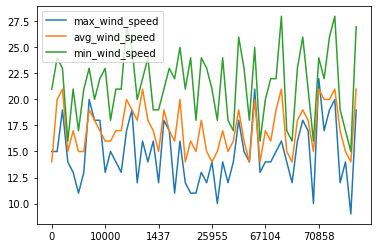

<Figure size 432x288 with 0 Axes>

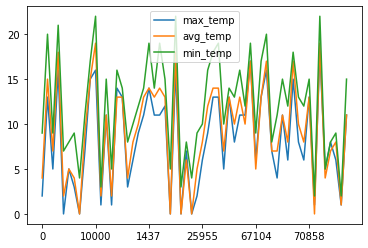

In [112]:
plt.figure()
df_final[['max_wind_speed', 'avg_wind_speed', 'min_wind_speed']].iloc[::1000].plot()
plt.show()
plt.figure()
df_final[['max_temp', 'avg_temp', 'min_temp']].iloc[::1000].plot()
plt.show()

### Correlation

As we can see, out target is not really correlated to any of the features. This matrix however allows us to see features that are correlated between them and therefore can be avoided to prevent overfitting.

In [77]:
corr = df_final.corr()
corr.style.background_gradient(cmap='coolwarm')

,countryName,eprtrSectorName,FacilityInspireID,facilityName,City,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
countryName,1.000000,0.035696,0.199345,-0.082877,-0.103855,0.006564,0.004534,-0.002128,-0.004073,0.006739,0.001611,0.004255,0.005657,0.005578,0.005807,0.460077,0.020568,0.010701
eprtrSectorName,0.035696,1.000000,0.027690,-0.009167,0.001449,-0.005707,0.025045,-0.003797,0.004322,0.002149,0.001217,-0.000366,-0.000813,-0.000138,-0.000693,0.035200,0.623711,0.537526
FacilityInspireID,0.199345,0.027690,1.000000,0.062949,-0.069663,-0.003473,-0.031296,0.002350,-0.006791,0.000977,-0.001540,-0.002308,-0.000309,0.000802,-0.001042,0.267175,-0.020444,-0.024694
facilityName,-0.082877,-0.009167,0.062949,1.000000,0.091638,-0.003260,0.003999,-0.000311,-0.007992,0.001236,0.003649,0.007565,0.002139,0.000959,0.000589,-0.002185,0.020584,0.022744
City,-0.103855,0.001449,-0.069663,0.091638,1.000000,-0.007135,0.014530,-0.002623,-0.009550,-0.005584,-0.003702,-0.006488,-0.000344,0.001319,0.000700,-0.124393,0.030607,0.030908
pollutant,0.006564,-0.005707,-0.003473,-0.003260,-0.007135,1.000000,-0.016746,0.003466,0.006863,-0.007398,-0.003738,-0.005805,0.001558,0.000704,0.001577,0.012328,-0.000971,0.001866
reportingYear,0.004534,0.025045,-0.031296,0.003999,0.014530,-0.016746,1.000000,0.003686,-0.008303,0.009251,0.007578,0.008077,0.004005,0.002201,0.000713,-0.010021,0.043632,0.042843
MONTH,-0.002128,-0.003797,0.002350,-0.000311,-0.002623,0.003466,0.003686,1.000000,-0.000880,0.004568,0.003257,0.000087,-0.163021,-0.167635,-0.162423,-0.008228,-0.002143,-0.000559
DAY,-0.004073,0.004322,-0.006791,-0.007992,-0.009550,0.006863,-0.008303,-0.000880,1.000000,-0.003665,-0.005773,-0.002681,0.001200,0.000102,0.001366,-0.000459,0.000012,-0.001197
max_wind_speed,0.006739,0.002149,0.000977,0.001236,-0.005584,-0.007398,0.009251,0.004568,-0.003665,1.000000,0.744871,0.561229,-0.003946,-0.002710,-0.002800,-0.008057,0.004410,0.004471


### Interesting columns

In [314]:
cols = ["reportingYear", "MONTH", "DAY", "avg_wind_speed", "avg_temp", "countryName", "eprtrSectorName", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "EPRTRSectorCode"]

In [315]:
from sklearn.model_selection import train_test_split

target = 'pollutant'
y = df_final[target].to_numpy()
X = df_final.drop(target, axis = 1)[cols].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

### PCA

### 2D

In [340]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X[::20])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf['target'] = pd.Categorical(y[::20])

<Figure size 720x720 with 0 Axes>

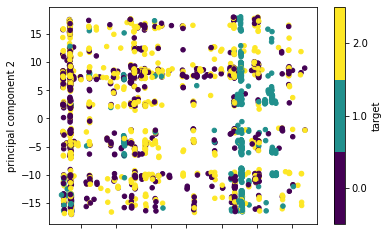

In [342]:
fig = plt.figure(figsize=(10,10))
principalDf.plot.scatter('principal component 1', 'principal component 2', c='target', colormap='viridis')
plt.show()

### 3D

In [343]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X[::20])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf['target'] = pd.Categorical(y[::20])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


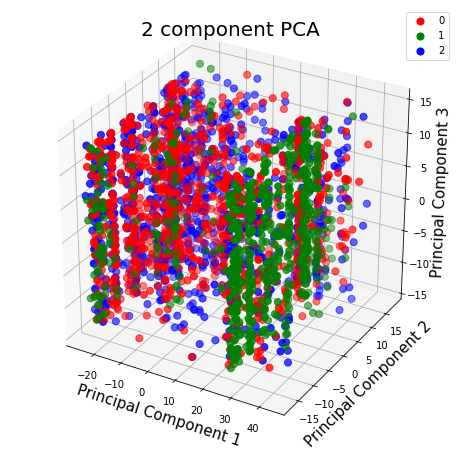

In [344]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'],
               principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.show()

As we can see the problem is not trivial. Class 1 seems to be more easily separated, but classes 0 and 2 are a mess. We will try different approaches considering this information.

## Models

Model handler class to perform grid search on models. Not runned on this notebook; runed on another colab for paralelizin issues.

In [371]:
import scipy
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt 

class Utils(object):

    def func_overX(self, X):
        Y = []
        for element in X:
            Y.append(sum(element.flatten()) > element.flatten().shape[0] // 2)
        return np.asarray(Y)

    def _ensure_dimensionalit(self, arr):
        return arr if len(arr[0].shape) == 1 else [x.flatten() for x in arr]

    def _acc(self, y_pred, y_target):

        if type(y_pred) == np.array and type(y_target) == np.array:
            assert(y_pred.shape == y_target.shape)
            mask = y_pred == y_target

        else:
            assert(len(y_pred) == len(y_target))
            mask = [x == y for x, y in zip(y_pred, y_target)]
        return sum(mask)/len(mask)

    def do_scaling(self, X):
        Scaler = StandardScaler()
        return Scaler.fit_transform(X)

    def _gen_gridSearch(self, model, hyperparams, n_splits=5):
        cv = StratifiedShuffleSplit(
            n_splits=n_splits, test_size=0.2, random_state=42)
        grid = GridSearchCV(model, param_grid=hyperparams,
                            cv=cv, n_jobs=6, verbose=0)
        return grid

    def df_Grid(self):
        if self.grid_flag:
            c = self.grid.__dict__['cv_results_']['params']
            a = ['params'] + \
                [f'split{n}_test_score' for n in range(self.n_splits)]
            data = pd.DataFrame({h: i for h, i in zip(
                a, (c, *[self.grid.__dict__['cv_results_'][f'split{n}_test_score'] for n in range(self.n_splits)]))})
            
            data[list(data['params'][0].keys())] = pd.DataFrame(data['params'].tolist())
            
            return data
        else:
            print('Grid has not been calculated')
                       
    def ci(self, alpha):
        def f(x):
            return scipy.stats.t.interval(alpha = alpha, df = self.n_splits - 1, loc = x['mean'], scale = x['sem'])
        return f

    def top_params(self, alpha = 0.95, n = None): #retorna els parametres amb millor ci acc
        df = self.df_Grid()
        df['mean'] = df.filter(regex='test').mean(axis = 1) #agafem columnes nombrades 'split*' calculem mitja
        df['sem'] = df.filter(regex='test').apply(scipy.stats.sem, axis = 1) + 1e-8 #standard error of mean
        df['ci'] = df.apply(self.ci(alpha), axis = 1)
        df['sort'] = [0.5 * x[1] - abs(x[0] - x[1]) * 0.5 for x in df['ci']] 
        df = df.sort_values('sort', ascending=False)
        
        if n:
            return df[:n]
        return df[:]

    def boxplots(self, n_params=10, duplicates=False):  # for top_params_df
        df = self.top_params(0.95, n_params)
        
        df['name'] = df[list(pd.DataFrame(df['params'].tolist()))].astype(str).agg('-'.join, axis=1)
        df = df.loc[:, df.columns.str.contains('score|name')].set_index('name')
        if not duplicates:
            df.drop_duplicates(inplace = True)
        df = pd.DataFrame(pd.DataFrame(df.unstack('name'), columns=[
                        'value']).droplevel(0)).reset_index(level=0)

        sns.set(font='Gill Sans', font_scale=1.2,
                palette='pastel', style="whitegrid")

        fig = plt.figure(figsize=(13, 6))
        ax = fig.add_subplot(111)

        # Plot with horizontal boxes
        sns.boxplot(x='value', y='name', data=df, width=0.6)

        # Tweak the visual presentation
        ax.xaxis.grid(True)
        ax.set(xlabel="Accuracy", ylabel="")
        sns.despine(trim=True, left=True, bottom=True)
        plt.title(f"{n_params} Splits Boxplots {str(self.model.__class__).split('.')[-1][:-2]}")
        plt.show()


In [372]:
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import pickle

class ModelHandler(Utils):

    models = {'SVM': svm.SVC, 'KNN': neighbors.KNeighborsClassifier,
              'DT': tree.DecisionTreeClassifier, 'XGB': XGBClassifier}
    hyperparams = {'SVM': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': np.logspace(-2, 10, 3),
    }, 'KNN': {
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'n_neighbors': np.arange(3, 10, 2),
        'p': np.arange(1, 3),
    }, 'DT': {
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'splitter': ['best', 'random'],
    }, 'XGB': {
    	'booster': ['gbtree', 'gblinear'],
        'min_child_weight': [0.5, 1, 3, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 1.0, 2.0],
        'max_depth': [4, 26, 32, 64 ]
    }}

    def __init__(self, X, Y, model: str, **kwargs):

        super().__init__()

        self.n_splits = kwargs['n_splits'] if 'n_splits' in kwargs else 5
        if 'n_splits' in kwargs:
            del kwargs['n_splits']
        self.hyperparam = self.hyperparams[model]
        self.hyperparam.update(kwargs)
        self.model = self.models[model](
            **{x: kwargs[x][0] if type(kwargs[x]) == list else kwargs[x] for x in kwargs})
        self.X = self.do_scaling(self._ensure_dimensionalit(X))
        self.Y = Y
        assert(len(Y.shape) == 1)
        self.grid = self._gen_gridSearch(
            self.model, self.hyperparam, self.n_splits)
        self.grid_flag = False

    def fit(self, with_score=True, with_grid=True):
        if with_grid:
            self.grid_flag = True
            self.grid.fit(self.X, self.Y)
            print(f"[INFO] The best parameters are {self.grid.best_params_}")
            print(f"[INFO] The best score is {self.grid.best_score_:.4f}")
            top_vals = self.top_params(0.95, 1).params.values[0]
            print(f"[INFO] The best parameters according to ci are {top_vals}")
            self.model = self.model.__class__(**top_vals)
            self.model.fit(self.X, self.Y)
        else:
            self.model = self.model.fit(self.X, self.Y)
        if with_score:
            pred = self.predict(self.X)
            print(f"[INFO] Train acc  is : {self._acc(pred, self.Y):.4f}")

    def predict(self, X):
        X = self._ensure_dimensionalit(X)
        return self.model.predict(self.do_scaling(X))

    def available_models(self):
        return self.models.keys()
    
    def save(self, name = False):
        if not name:
            name = str(self.model.__class__).split('.')[-1][:-2]
        pickle.dump(self.model, open(name + '.pickle','wb'))
    
    def load(self,path):
        self.model = pickle.load(open(path,'rb'))

### XGBOOST

Our first approach (and the best one) has been an XGBOOST.

In [80]:
!pip install xgboost

#### Training

In [253]:
from xgboost import XGBClassifier

# fit model no training data
model_012 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_012.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
              n_estimators=1000, nthread=4, objective='multi:softprob',
              scale_pos_weight=0.8, seed=27, subsample=0.8,
              weight=[1.0, 0.2, 1.0])

In [254]:
from sklearn.metrics import classification_report

# make predictions for train data
y_pred = model_012.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     14005
         1.0       0.98      0.92      0.95     10121
         2.0       0.89      0.94      0.91     15829

    accuracy                           0.92     39955
   macro avg       0.93      0.92      0.92     39955
weighted avg       0.92      0.92      0.92     39955



#### Testing

In [255]:
from sklearn.metrics import classification_report

# make predictions for test data
y_pred = model_012.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48      6002
         1.0       0.91      0.83      0.87      4338
         2.0       0.53      0.59      0.56      6784

    accuracy                           0.60     17124
   macro avg       0.64      0.63      0.63     17124
weighted avg       0.61      0.60      0.61     17124



### One-vs-One

During our experiment we've seen that the models can easily distinguish the class 1 from the other ones, but has a hard time when predicting 0 vs 2. For this reason we've decided to opt for a One-vs-One strategy, where we create three models to perform binary classification:
- Model 0-1
- Model 1-2
- Model 0-2
We can later use the three to decide which class is more likely to be the right one.

#### Model 0-1

In [244]:
df_binary = df_final[df_final.pollutant != 2].copy()
#df_binary["pollutant"] = df_binary["pollutant"].replace({2.0: 1.0})
df_binary

,countryName,eprtrSectorName,FacilityInspireID,facilityName,City,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,10,4,6787,3390,4139,0.0,2015,10,20,15,14,21,2,4,9,2,20,2
2,28,8,1328,1439,3349,1.0,2019,2,4,12,14,17,1,4,8,2,50,4
4,8,8,6222,6879,4453,1.0,2018,12,22,17,20,21,11,11,16,2,52,4
6,9,4,2051,7371,901,0.0,2008,5,5,12,15,21,10,13,16,1,23,2
7,22,6,4591,487,2234,0.0,2011,4,11,9,14,19,11,12,17,2,55,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,31,8,6211,1993,1176,1.0,2019,7,18,9,15,16,12,14,17,5,-1,-1
51,31,8,6145,5593,1523,1.0,2019,8,20,12,16,23,6,0,12,3,-1,-1
57,31,2,6218,6514,4152,1.0,2019,4,16,12,14,18,15,1,2,6,-1,-1
64,31,8,6156,4351,1118,1.0,2019,10,27,13,14,22,9,9,12,9,-1,-1


In [245]:
from imblearn.under_sampling import AllKNN

target = 'pollutant'
y = df_binary[target].to_numpy()
X = df_binary.drop(target, axis = 1)[cols].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

allknn = AllKNN()
X_train, y_train = allknn.fit_resample(X_train, y_train)

In [227]:
# fit model no training data
model_01 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_01.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
              n_estimators=1000, nthread=4, scale_pos_weight=0.8, seed=27,
              subsample=0.8)

In [228]:
from sklearn.metrics import classification_report

# make predictions for train data
y_pred = model_01.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98      9789
         1.0       1.00      0.95      0.98     10121

    accuracy                           0.98     19910
   macro avg       0.98      0.98      0.98     19910
weighted avg       0.98      0.98      0.98     19910



In [229]:
from sklearn.metrics import classification_report

# make predictions for test data
y_pred = model_01.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      6002
         1.0       0.84      0.90      0.87      4338

    accuracy                           0.89     10340
   macro avg       0.88      0.89      0.89     10340
weighted avg       0.89      0.89      0.89     10340



#### Model 1-2

In [230]:
df_binary = df_final[df_final.pollutant != 0].copy()
df_binary

,countryName,eprtrSectorName,FacilityInspireID,facilityName,City,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
1,15,4,3413,6713,4366,2.0,2018,9,21,19,19,21,5,7,12,1,19,2
2,28,8,1328,1439,3349,1.0,2019,2,4,12,14,17,1,4,8,2,50,4
3,5,2,565,2634,2119,2.0,2012,8,6,11,16,17,10,10,15,0,2,0
4,8,8,6222,6879,4453,1.0,2018,12,22,17,20,21,11,11,16,2,52,4
5,30,2,326,7481,1110,2.0,2009,11,26,13,16,18,0,1,3,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,31,8,6145,5593,1523,1.0,2019,8,20,12,16,23,6,0,12,3,-1,-1
57,31,2,6218,6514,4152,1.0,2019,4,16,12,14,18,15,1,2,6,-1,-1
60,31,6,6178,6788,175,2.0,2019,1,14,8,14,19,4,4,6,17,-1,-1
64,31,8,6156,4351,1118,1.0,2019,10,27,13,14,22,9,9,12,9,-1,-1


In [231]:
target = 'pollutant'
y = df_binary[target].to_numpy()
X = df_binary.drop(target, axis = 1)[cols].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

allknn = AllKNN()
X_train, y_train = allknn.fit_resample(X_train, y_train)

In [232]:
# fit model no training data
model_12 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_12.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
              n_estimators=1000, nthread=4, scale_pos_weight=0.8, seed=27,
              subsample=0.8)

In [233]:
from sklearn.metrics import classification_report

# make predictions for train data
y_pred = model_12.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99     10121
         2.0       0.98      0.99      0.99      9916

    accuracy                           0.99     20037
   macro avg       0.99      0.99      0.99     20037
weighted avg       0.99      0.99      0.99     20037



In [234]:
from sklearn.metrics import classification_report

# make predictions for test data
y_pred = model_12.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.76      0.91      0.83      4338
         2.0       0.94      0.81      0.87      6784

    accuracy                           0.85     11122
   macro avg       0.85      0.86      0.85     11122
weighted avg       0.87      0.85      0.85     11122



#### Model 0-2

In [235]:
df_binary = df_final[df_final.pollutant != 1].copy()
df_binary

,countryName,eprtrSectorName,FacilityInspireID,facilityName,City,pollutant,reportingYear,MONTH,DAY,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,10,4,6787,3390,4139,0.0,2015,10,20,15,14,21,2,4,9,2,20,2
1,15,4,3413,6713,4366,2.0,2018,9,21,19,19,21,5,7,12,1,19,2
3,5,2,565,2634,2119,2.0,2012,8,6,11,16,17,10,10,15,0,2,0
5,30,2,326,7481,1110,2.0,2009,11,26,13,16,18,0,1,3,2,0,0
6,9,4,2051,7371,901,0.0,2008,5,5,12,15,21,10,13,16,1,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,31,2,6142,2907,1106,2.0,2019,1,3,11,16,21,8,8,10,10,-1,-1
47,31,2,6182,5180,3407,2.0,2019,8,4,17,19,21,1,15,17,14,-1,-1
60,31,6,6178,6788,175,2.0,2019,1,14,8,14,19,4,4,6,17,-1,-1
68,31,6,6191,1549,2031,0.0,2019,5,26,17,17,25,15,16,18,13,-1,-1


In [236]:
target = 'pollutant'
y = df_binary[target].to_numpy()
X = df_binary.drop(target, axis = 1)[cols].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

allknn = AllKNN()
X_train, y_train = allknn.fit_resample(X_train, y_train)

In [237]:
# fit model no training data
model_02 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=0.8,
    seed=27
)

model_02.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=10,
              n_estimators=1000, nthread=4, scale_pos_weight=0.8, seed=27,
              subsample=0.8)

In [238]:
from sklearn.metrics import classification_report

# make predictions for train data
y_pred = model_02.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91     14005
         2.0       0.98      0.67      0.80      8508

    accuracy                           0.87     22513
   macro avg       0.91      0.83      0.85     22513
weighted avg       0.89      0.87      0.87     22513



In [239]:
from sklearn.metrics import classification_report

# make predictions for test data
y_pred = model_02.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.90      0.64      6002
         2.0       0.68      0.19      0.30      6784

    accuracy                           0.52     12786
   macro avg       0.59      0.55      0.47     12786
weighted avg       0.59      0.52      0.46     12786



#### Predictions with three models

In [272]:
# make predictions for test data
y_pred_01 = model_01.predict(X_test)
y_pred_12 = model_12.predict(X_test)
y_pred_02 = model_02.predict(X_test)

y_pred_merged = np.array([y_pred_01, y_pred_12, y_pred_02])
y_pred = []

In [273]:
for i in range(len(y_pred_merged)):
    lst = list(y_pred_merged[:-1,i])
    most_freq = max(lst, key=lst.count)
    y_pred.append(most_freq)

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48      6002
         1.0       0.91      0.83      0.87      4338
         2.0       0.53      0.59      0.56      6784

    accuracy                           0.60     17124
   macro avg       0.64      0.63      0.63     17124
weighted avg       0.61      0.60      0.61     17124



### Other tasks

#### Hyperparameter search

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

# fit model no training data
model = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = model,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19,
                                                         20]},
                   random_state=35, verbose=2)

In [119]:
# this prints the contents of the parameters in the random grid
print ('Random grid: ', random_grid, '\n')

# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 6, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}  



In [121]:
model = RandomForestClassifier(**rf_random.best_params_)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=6)

In [122]:
from sklearn.metrics import classification_report

# make predictions for train data
y_pred = model.predict(X_train)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59     14005
         1.0       0.95      0.83      0.88     10121
         2.0       0.60      0.63      0.62     15829

    accuracy                           0.67     39955
   macro avg       0.71      0.69      0.70     39955
weighted avg       0.68      0.67      0.67     39955



In [123]:
from sklearn.metrics import classification_report

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51      6002
         1.0       0.94      0.81      0.87      4338
         2.0       0.53      0.56      0.55      6784

    accuracy                           0.61     17124
   macro avg       0.65      0.63      0.64     17124
weighted avg       0.62      0.61      0.61     17124



In [124]:
from sklearn.model_selection import cross_val_score

print("model")
cv_res = cross_val_score(model, X_test, y_test, scoring="accuracy", cv = 5)
print("cv:", cv_res)
mean_score = cv_res.mean()
std_score = cv_res.std()
print("mean:", mean_score)
print("std:", std_score)

model
cv: [0.60379562 0.61343066 0.5979562  0.58890511 0.60952103]
mean: 0.6027217238556518
std: 0.008668033771746032


### Deep Learning

Even though we were limited by the time and the resources, we've also tried an approach based on an MLP classifier implemented in Pytorch, but the first experiments didn't show good results so we've decided to stick with a ML approach.

In [29]:
import torch
import torch.nn as nn

In [42]:
class MultiClassMLP(nn.Module):

  def __init__(self, inp_dim, num_class, num_hidden_units, depth = 1):
    super(MultiClassMLP, self).__init__()
    self.depth = depth
    # Layers
    self.linear_in = nn.Linear(inp_dim, num_hidden_units)
    self.linear_hidden = nn.ModuleList([torch.nn.Linear(num_hidden_units, num_hidden_units) for i in range(depth)])
    self.linear_out = nn.Linear(num_hidden_units, num_class)
    # Activation
    self.relu = nn.LeakyReLU()
    self.softmax = nn.Softmax()

  def forward(self, x):
    x = self.linear_in(x)
    x = self.relu(x)
    for depth in range(self.depth):
      x = self.linear_hidden[depth](x)
      x = self.relu(x)
    x = self.linear_out(x)
    #x = self.softmax(x) #comment if using CrossEntropyLoss
    return x

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
D = 11  # input dimensions
C = 3  # num_classes
H = 64  # num_hidden_units
P = 10 # depth
modelMLP = MultiClassMLP(D, C, H, P)
modelMLP = modelMLP.to(device)

In [52]:
criterion = torch.nn.CrossEntropyLoss()

In [53]:
learning_rate = 3e-3
lambda_l2 = 1e-6

# we use the optim package to apply gradient descent for our parameter updates
#optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=learning_rate, weight_decay=lambda_l2)

In [54]:
#@title The code in this cell is just for visualization no need to worry about it. Just hit the play button before continuing { display-mode: "form" }
# Dont worry about the code in this cell it is just for visualization purposes you dont need to understand or edit it yet

import matplotlib.pyplot as plt
from IPython import display

def plot_model(x, y, model, axis):

    mesh = torch.arange(-2, 2, 0.01)

    xx, yy = torch.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data.cuda().detach())
    Z = Z.max(1)[1].reshape(xx.shape)
    axis.contourf(xx, yy, Z.cpu(), cmap=plt.cm.coolwarm, alpha=0.3)
    axis.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.cpu(), s=20, cmap=plt.cm.coolwarm)
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])


def plot_regressor(x, y, model, axis):
    
    with torch.no_grad():
        y_pred = model(x).detach()
    axis.scatter(x.cpu(), y.cpu())
    axis.plot(x.cpu(), y_pred.cpu(), 'r-', lw=5, label="Model Prediction")
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])

def draw_plots(x, y, model, losses, visualize_surface = False, visualize_regressor = False):

    if visualize_surface and visualize_regressor:
        raise ValueError("Expected only one of 'visualize_error' or 'visualize_regressor' to be True.")

    if visualize_surface:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Output Space")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_model(x, y, model, ax[0])
    
    elif visualize_regressor:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Validation Data")
        ax[1].set_title("Losses")
        ax[1].plot(losses["train"], label="training loss")
        ax[1].plot(losses["val"], label="validation loss")
        ax[1].set_xlabel("Epoch")
        plot_regressor(x, y, model, ax[0])

    else:
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
    
    plt.legend()
    plt.pause(0.000001)
    plt.show()   

In [55]:
# Training loop

def train(x_train, y_train, x_val, y_val, criterion, model, optimizer, epochs=300, visualize_surface=False):
    
    losses = {"train": [], "val": []} # Two lists to keep track of the evolution of our losses

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train) # x_train is the whole batch, so we are doing batch gradient descent
    
        # Compute the loss
        loss = criterion(y_pred, y_train)
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        # Compute the accuracy.
        score, predicted = torch.max(y_pred, 1) # torch.max() returns the maximum value and the argmax (index of the maximum value)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        losses["train"].append(loss.cpu().detach().numpy()) # keep track of our training loss

        # Run model on validation data
        val_loss, val_acc = calculateLossAcc(criterion, model, x_val, y_val) # Call our helper function on the validation set
        losses["val"].append(val_loss.cpu().detach().numpy()) # keep track of our validation loss

        # Create plots
        #display.clear_output(wait=True)
        #draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor = False)

        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))        
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        
    return losses # In case we want to plot them afterwards

# A helper function that calculates our loss and accuracy on a given dataset (by default on our validation set)
def calculateLossAcc(criterion, model, x, y):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    loss = criterion(y_pred.squeeze(), y)
    acc = (y == predicted).sum().float() / len(y)

    return loss, acc

In [56]:
X_train = torch.tensor(X_train).type(torch.FloatTensor).to(device)
y_train = torch.tensor(y_train).type(torch.LongTensor).to(device)
X_test = torch.tensor(X_test).type(torch.FloatTensor).to(device)
y_test = torch.tensor(y_test).type(torch.LongTensor).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [58]:
losses = train(X_train, y_train, X_test, y_test, criterion, modelMLP, optimizer, visualize_surface=True, epochs = 1500)

Training: [EPOCH]: 0, [LOSS]: 0.894011, [ACCURACY]: 0.529
Validation: [EPOCH]: 0, [LOSS]: 0.881787, [ACCURACY]: 0.531
Training: [EPOCH]: 1, [LOSS]: 0.881180, [ACCURACY]: 0.531
Validation: [EPOCH]: 1, [LOSS]: 0.888016, [ACCURACY]: 0.528
Training: [EPOCH]: 2, [LOSS]: 0.886517, [ACCURACY]: 0.529
Validation: [EPOCH]: 2, [LOSS]: 0.881757, [ACCURACY]: 0.531
Training: [EPOCH]: 3, [LOSS]: 0.882401, [ACCURACY]: 0.530
Validation: [EPOCH]: 3, [LOSS]: 0.881271, [ACCURACY]: 0.533
Training: [EPOCH]: 4, [LOSS]: 0.881191, [ACCURACY]: 0.534
Validation: [EPOCH]: 4, [LOSS]: 0.885270, [ACCURACY]: 0.524
Training: [EPOCH]: 5, [LOSS]: 0.883315, [ACCURACY]: 0.524
Validation: [EPOCH]: 5, [LOSS]: 0.877418, [ACCURACY]: 0.532
Training: [EPOCH]: 6, [LOSS]: 0.876542, [ACCURACY]: 0.533
Validation: [EPOCH]: 6, [LOSS]: 0.881447, [ACCURACY]: 0.531
Training: [EPOCH]: 7, [LOSS]: 0.882090, [ACCURACY]: 0.530
Validation: [EPOCH]: 7, [LOSS]: 0.877896, [ACCURACY]: 0.532
Training: [EPOCH]: 8, [LOSS]: 0.876313, [ACCURACY]: 0.53

## Final predictions

In [358]:
df_test = pd.read_csv(test_data_dir_csv, index_col=0)
df_test

,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,reportingYear,...,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
test_index,,,,,,,,,,,,,,,,,,,,,
0,Poland,3,Mineral industry,3(a),Underground mining and related operations,PL.MŚ/000002357.FACILITY,Polska Grupa Górnicza sp. z o.o. Oddział KWK R...,Rydułtowy,AIR,2017,...,EUROPE,14.080054,14.855940,18.474836,10.278561,11.381181,13.480752,1,Brittany Buck,826b1de9dad293ae3e4f9cbaf6cf3420
1,Luxembourg,5,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,LU.CAED/000012000.FACILITY,Sidec,Diekirch,AIR,2008,...,EUROPE,16.052425,17.623877,22.622900,6.625910,8.840137,13.422924,0,Lauren Fisher,ed30a6667b40ba0a66198b3173e7353f
2,Netherlands,1,Energy sector,1(c),Thermal power stations and other combustion in...,NL.EEA/212857.FACILITY,Nuon Power Generation BV (Eemshaven),Eemshaven,AIR,2014,...,EUROPE,13.647318,15.541979,17.818521,5.669436,8.403322,11.276388,2,Linda Thompson,78e1082c3cfef3bdf3554da8d6afcc34
3,Sweden,5,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,SE.CAED/10013901.Facility,HÖGBYTORPS AVFALLSANLÄGGNING,BRO,AIR,2011,...,EUROPE,16.336762,17.458113,19.961777,6.160560,7.571596,9.443572,2,Bethany Mcmillan,27f959641950d381869d746d7d0e7d4e
4,Portugal,1,Energy sector,1(c),Thermal power stations and other combustion in...,PT.EEA/133926.FACILITY,SPCG - Sociedade Portuguesa de Co-Geração Eléc...,SETÚBAL,AIR,2010,...,EUROPE,21.516602,20.532473,21.617137,10.964012,11.548033,12.624114,2,Sarah Hoffman,1cb71655d9e0bd5cedb2320bf5fdd8f7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24475,Austria,1,Energy sector,1(c),Thermal power stations and other combustion in...,AT.CAED/9008390486467.FACILITY,Trans Austria Gasleitung GmbH,Lechen,AIR,2014,...,EUROPE,11.243493,16.527223,18.114884,3.194254,3.901992,6.437241,2,Crystal Ramirez,a4c235acc3cd402a365de2ff369aa5b1
24476,Spain,1,Energy sector,1(c),Thermal power stations and other combustion in...,ES.CAED/003589000.FACILITY,CENTRAL TÉRMICA DE ESCOMBRERAS,CARTAGENA,AIR,2007,...,EUROPE,14.645536,17.044528,24.602476,9.358224,8.708120,13.258552,0,Amber Grant,d43a0adde7c3a944e7ed740a2114e4a9
24477,Finland,5,Waste and wastewater management,5(d),Landfills (excluding landfills of inert waste ...,http://paikkatiedot.fi/so/1002031/pf/Productio...,"Etelä-Karjalan Jätehuolto Oy, Jätekeskus",Konnunsuo,AIR,2019,...,EUROPE,16.789255,18.595172,24.997173,12.047347,14.686131,17.699271,2,Tiffany Smith,1b2b2db0d413ec0745c8c108317b9529


In [354]:
for col in df_test.columns:
    if col != "pollutant":
        if is_string_dtype(df_test[col]):
            print("str", col)
            df_test[col] = df_test[col].astype('category').cat.codes
        elif is_numeric_dtype(df_test[col]):
            print("int", col)
            df_test[col] = df_test[col].astype(np.int64)

str countryName
int EPRTRSectorCode
str eprtrSectorName
str EPRTRAnnexIMainActivityCode
str EPRTRAnnexIMainActivityLabel
str FacilityInspireID
str facilityName
str City
str targetRelease
int reportingYear
int MONTH
int DAY
str CONTINENT
int max_wind_speed
int avg_wind_speed
int min_wind_speed
int max_temp
int avg_temp
int min_temp
int DAY WITH FOGS
str REPORTER NAME
str CITY ID


In [357]:
df_test

,countryName,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,reportingYear,...,CONTINENT,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID
test_index,,,,,,,,,,,,,,,,,,,,,
0,22,3,4,17,68,4002,4259,3160,0,2017,...,0,14,14,18,10,11,13,1,2844,2208
1,18,5,8,50,57,3413,5239,1020,0,2008,...,0,16,17,22,6,8,13,0,12658,4031
2,20,1,2,2,63,3448,3905,1143,0,2014,...,0,13,15,17,5,8,11,2,12924,2033
3,29,5,8,50,57,4399,2788,369,0,2011,...,0,16,17,19,6,7,9,2,2164,659
4,23,1,2,2,63,4153,4990,3338,0,2010,...,0,21,20,21,10,11,12,2,18330,472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24475,0,1,2,2,63,9,5734,2106,0,2014,...,0,11,16,18,3,3,6,2,4647,2770
24476,28,1,2,2,63,1234,868,635,0,2007,...,0,14,17,24,9,8,13,0,791,3599
24477,8,5,8,50,57,5356,2206,1892,0,2019,...,0,16,18,24,12,14,17,2,20181,445


In [355]:
X_test = df_test[cols].to_numpy()

In [356]:
y_pred = model_012.predict(X_test)

In [366]:
results = pd.DataFrame()

results["test_index"] = list(df_test.index)
results["pollutant"] = y_pred

In [367]:
results

,test_index,pollutant
0,0,1.0
1,1,1.0
2,2,0.0
3,3,1.0
4,4,2.0
...,...,...
24475,24475,0.0
24476,24476,2.0
24477,24477,1.0
24478,24478,0.0


In [368]:
results.to_csv("/content/drive/MyDrive/Data_Science_&_AI/NUWE/predictions.csv", index=False)

In [370]:
results.to_json("/content/drive/MyDrive/Data_Science_&_AI/NUWE/predictions.json")